In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
dataloader = {
'train_set' :torch.utils.data.DataLoader( torchvision.datasets.CIFAR10(root='./data', train=True, download=True,
                                         transform=transforms.Compose([
                                             transforms.Resize((64, 64)),
                                             transforms.ToTensor()
                                         ]))),

'test_set' :torch.utils.data.DataLoader( torchvision.datasets.CIFAR10(root='./data', train=False, download=True,
                                        transform=transforms.Compose([
                                            transforms.Resize((64, 64)),
                                            transforms.ToTensor()
                                        ])))
}

100%|██████████| 170498071/170498071 [00:05<00:00, 29559402.06it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


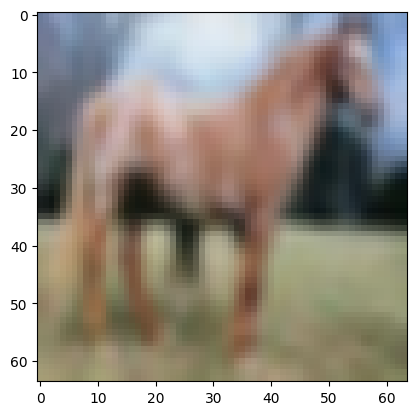

In [ ]:
import random
import matplotlib.pyplot as plt

ix = random.randint(0, len(train_imgs))
img, label = train_imgs[ix], train_labels[ix]

plt.imshow(img)

plt.show()

In [ ]:
pool = torch.nn.MaxPool2d(5, padding=0, stride=2)

img_tensor = torch.from_numpy(img / 255.).unsqueeze(0).permute(0, 3, 1, 2).float()
output = pool(img_tensor)
output.shape

torch.Size([1, 3, 30, 30])

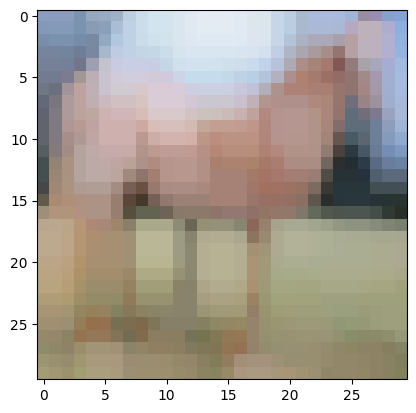

In [ ]:
plt.imshow(output.squeeze(0).permute(1,2,0))
plt.show()

In [ ]:
def block(c_in, c_out, k=5, p=0, s=2, pk=2, ps=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

def block2(c_in, c_out):
    return torch.nn.Sequential(
        torch.nn.Linear(c_in, c_out),
        torch.nn.ReLU()
    )

class CNN(torch.nn.Module):
  def __init__(self, n_channels=3, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 64)
    self.conv2 = block(64, 128)
    self.conv3 = block(128,256 )
    self.conv4 = block(256,512)
    self.fc = torch.nn.Linear(512 * 7 * 7, n_outputs)

  def forward(self, x):
    print("Dimensiones:")
    print("Entrada: ", x.shape)
    x = self.conv1(x)
    print("conv1: ", x.shape)
    x = self.conv2(x)
    print("conv2: ", x.shape)
    x = self.conv3(x)
    print("conv3: ", x.shape)
    x = self.conv4(x)
    print("conv4: ", x.shape)
    x = x.view(x.shape[0], -1)
    print("pre fc: ", x.shape)
    x = self.fc(x)
    print("Salida: ", x.shape)
    return x

In [ ]:
def block(c_in, c_out, k=5, p=0, s=2, pk=2, ps=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

def block2(c_in, c_out):
    return torch.nn.Sequential(
        torch.nn.Linear(c_in, c_out),
        torch.nn.ReLU()
    )

class CNN(torch.nn.Module):
  def __init__(self, n_channels=3, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 256)
    self.conv2 = block(256, 128)
    self.conv3 = block(128,64 )
    self.fc = torch.nn.Linear(64 * 3 * 3, n_outputs)

  def forward(self, x):
    print("Dimensiones:")
    print("Entrada: ", x.shape)
    x = self.conv1(x)
    print("conv1: ", x.shape)
    x = self.conv2(x)
    print("conv2: ", x.shape)
    x = self.conv3(x)
    print("conv3: ", x.shape)
    x = x.view(x.shape[0], -1)
    print("pre fc: ", x.shape)
    x = self.fc(x)
    print("Salida: ", x.shape)
    return x

In [ ]:
model = CNN()

output = model(torch.randn(64, 3, 64, 64))

Dimensiones:
Entrada:  torch.Size([64, 3, 64, 64])
conv1:  torch.Size([64, 256, 29, 29])
conv2:  torch.Size([64, 128, 12, 12])
conv3:  torch.Size([64, 64, 3, 3])
pre fc:  torch.Size([64, 576])
Salida:  torch.Size([64, 10])


In [ ]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train_set'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test_set'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [ ]:
model = CNN().to(device)
fit(model, dataloader).to(device)

NameError: ignored